In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

## Load model parameters and mobility_heat

In [2]:
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

#load model parameters from R2Mlwin
df = pd.read_csv("/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/regression/params_clean_final_90_v1.csv")
df.columns = ['variable', 'estimate']

#load data set used for modelling
mob_vars = pd.read_csv("/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/mobility_heat/mobility_heat_dataset.csv")



In [6]:
#re-centre temperature variable
mob_vars['heat_temp'] = mob_vars['heat_temp_centered'] + 33

#### format variables for every year (as opposed to categorical), format binary variable for duration and coast

In [9]:
mob_vars['2020'] = [1 if x==2020 else 0 for x in mob_vars['year']]
mob_vars['2021'] = [1 if x==2021 else 0 for x in mob_vars['year']]
mob_vars['2022'] = [1 if x==2022 else 0 for x in mob_vars['year']]
mob_vars['hw_dur'] = [1 if x=='>5 days' else 0 for x in mob_vars['heatwave_dur']]
mob_vars['coast_binary'] = mob_vars['coast_binary']* 1


### make subset dataframe for every activity-type variable

In [10]:
df['workplaces'] = [1 if 'workplaces' in x else 0 for x in df['variable'] ]
df['residential'] = [1 if 'residential' in x else 0 for x in df['variable'] ]
df['grocery_pharmacy'] = [1 if 'grocery_pharmacy' in x else 0 for x in df['variable'] ]
df['parks'] = [1 if 'parks' in x else 0 for x in df['variable'] ]
df['retail'] = [1 if 'retail' in x else 0 for x in df['variable'] ]
df['transit'] = [1 if 'transit' in x else 0 for x in df['variable'] ]

In [11]:
residential = df[df['residential'] == 1].reset_index()
workplaces = df[df['workplaces'] == 1].reset_index()
grocery_pharmacy = df[df['grocery_pharmacy'] == 1].reset_index()
parks = df[df['parks'] == 1].reset_index()
retail = df[df['retail'] == 1].reset_index()
transit = df[df['transit'] == 1].reset_index()

### Format params into dataframe

In [12]:
dic = {}
for response in ['workplaces', 'residential', 'grocery_pharmacy', 'parks', 'retail', 'transit']:
    
    dic[response] = {}
    subset = df[df[response]==1].reset_index()
    dic[response]['global_intercept'] = subset.iloc[0, 2]
    dic[response]['heat_temp_centered_California'] = subset.iloc[1,2]
    dic[response]['British Columbia_intercept'] = subset.iloc[2,2]
    dic[response]['Oregon_intercept'] = subset.iloc[3,2]
    dic[response]['Washington_intercept'] = subset.iloc[4,2]
    dic[response]['heat_temp_centered_British Columbia'] = subset.iloc[5,2]
    dic[response]['heat_temp_centered_Oregon'] = subset.iloc[6,2]
    dic[response]['heat_temp_centered_Washington'] = subset.iloc[7,2]
    dic[response]['temp_diff'] = subset.iloc[8,2]
    dic[response]['stage_frac'] = subset.iloc[9,2]
    dic[response]['weekend'] = subset.iloc[10,2]
    dic[response]['year2021'] = subset.iloc[11,2]
    dic[response]['year2022'] = subset.iloc[12,2]
    dic[response]['hw_duration'] = subset.iloc[13,2]
    dic[response]['june_hw'] = subset.iloc[14,2]
    dic[response]['coast_binary'] = subset.iloc[15,2]
    dic[response]['temperature_2m_winter_British Columbia'] = subset.iloc[16,2]
    dic[response]['temperature_2m_winter_Oregon'] = subset.iloc[17,2]
    dic[response]['temperature_2m_winter_Washington'] = subset.iloc[18,2]
    dic[response]['popdens_dec'] = subset.iloc[19,2]
    dic[response]['income_dec'] = subset.iloc[20,2]
    dic[response]['over65_dec'] = subset.iloc[21,2]
    dic[response]['nonwhite_dec'] = subset.iloc[22,2]

### Create function which fixes all other variables for marginal effects calculation
* Gets the mean of each variable in the dataset, multiplies it by the corresponding parameter

In [14]:
def get_average_effects(dic, response, state):
    
    
    estimate_subset = dic[response]
    
    global_int = estimate_subset['global_intercept']
    
    #get each state's unique subset (average covariates are unique to each state)
    mob_vars_subset = mob_vars


    
    
    variable_sum = sum([estimate_subset['temp_diff']*mob_vars_subset['temp_diff'].mean(), 
                  estimate_subset['stage_frac']*mob_vars_subset['stage_frac'].mean(), 
                  estimate_subset['weekend']*mob_vars_subset['weekend'].mean(), 
                  estimate_subset['year2021']*mob_vars_subset.groupby('heat_ID')['2021'].mean().mean(),
                  estimate_subset['year2022']*mob_vars_subset.groupby('heat_ID')['2022'].mean().mean(), 
                  estimate_subset['hw_duration']*mob_vars_subset.groupby('heat_ID')['hw_dur'].mean().mean(), 
                  estimate_subset['june_hw']*mob_vars_subset.groupby('heat_ID')['june_hw'].mean().mean(), 
                  estimate_subset['coast_binary']*mob_vars_subset.groupby('location')['coast_binary'].mean().mean(),
                  estimate_subset['popdens_dec']*mob_vars_subset.groupby('location')['popdens_dec'].mean().mean(), 
                  estimate_subset['over65_dec']*mob_vars_subset.groupby('location')['over65_dec'].mean().mean(),
                  estimate_subset['income_dec']*mob_vars_subset.groupby('location')['income_dec'].mean().mean(), 
                  estimate_subset['nonwhite_dec']*mob_vars_subset.groupby('location')['nonwhite_dec'].mean().mean()])
        

    

    #average out total winter effect with global mean (this is unique because it is a bias in the data, we do not want 
    # to use it to parse out state-level differences, we want to negate its influence)
    
    #California is reference state in interaction terms, therefore add it to each state's slope/intercept parameters
    if state != 'California':
    
        slope = estimate_subset[f'heat_temp_centered_{state}'] + estimate_subset[f'heat_temp_centered_California']
        winter_temp_shift = estimate_subset[f'temperature_2m_winter_{state}']*0
        variable_sum += winter_temp_shift
        final_average = global_int + variable_sum + estimate_subset[f'{state}_intercept']
        print(state, response)

    else: 
        
        slope = estimate_subset[f'heat_temp_centered_California']
        final_average = global_int + variable_sum 
    
    params_dic = {}
        
    return [slope, final_average]




## Iterate through repsonses and states, create dictionary with intercepts and slopes

In [15]:
params_dic = {}
for response in ['workplaces', 'residential', 'grocery_pharmacy', 'retail', 'parks','transit' ]:
    params_dic[response] = {}
    for state in ['British Columbia', 'Washington', 'Oregon', 'California']:
        params_dic[response][state] = get_average_effects(dic, response, state)


British Columbia workplaces
Washington workplaces
Oregon workplaces
British Columbia residential
Washington residential
Oregon residential
British Columbia grocery_pharmacy
Washington grocery_pharmacy
Oregon grocery_pharmacy
British Columbia retail
Washington retail
Oregon retail
British Columbia parks
Washington parks
Oregon parks
British Columbia transit
Washington transit
Oregon transit


In [16]:
def plot_regression(response, params_dic):
    bc_line = np.poly1d(params_dic[response]['British Columbia'])
    wa_line = np.poly1d(params_dic[response]['Washington'])
    or_line = np.poly1d(params_dic[response]['Oregon'])
    ca_line = np.poly1d(params_dic[response]['California'])
    
    x_axis = np.linspace(-10,10,20)
    bc_y_axis = bc_line(x_axis)
    wa_y_axis = wa_line(x_axis)
    or_y_axis = or_line(x_axis)
    ca_y_axis = ca_line(x_axis)
    x_axis += 34
    BC_temp = mob_vars[mob_vars['state'] == "British Columbia"]['heat_temp'].mean()
    WA_temp = mob_vars[mob_vars['state'] == "Washington"]['heat_temp'].mean()
    OR_temp = mob_vars[mob_vars['state'] == "Oregon"]['heat_temp'].mean()
    CA_temp = mob_vars[mob_vars['state'] == "California"]['heat_temp'].mean()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    pos = ax.get_position()
    
    
    min_y = np.concatenate([bc_y_axis, wa_y_axis, or_y_axis, ca_y_axis]).min() 
    max_y = np.concatenate([bc_y_axis, wa_y_axis, or_y_axis, ca_y_axis]).max() 


    sns.lineplot(x=x_axis, y=bc_y_axis, ax =ax, label='BC', color='purple')
    sns.lineplot(x=x_axis, y=wa_y_axis, ax =ax, label='WA', color='green')
    sns.lineplot(x=x_axis, y=or_y_axis, ax =ax, label='OR', color='orange')
    sns.lineplot(x=x_axis, y=ca_y_axis, ax =ax, label='CA', color='red')
    
    
    plt.vlines(x=BC_temp, ymin=min_y, ymax=max_y, colors='purple', ls='--', lw=1, label='BC mean heatwave')
    plt.vlines(x=WA_temp, ymin=min_y, ymax=max_y, colors='green', ls='--', lw=1, label='WA mean heatwave')
    plt.vlines(x=OR_temp, ymin=min_y, ymax=max_y, colors='orange', ls='--', lw=1, label='OR mean heatwave')
    plt.vlines(x=CA_temp, ymin=min_y, ymax=max_y, colors='red', ls='--', lw=1, label='CA mean heatwave')
    
    plt.title(f"Percent change in {response} activity with heat wave temperature")
    plt.xlabel(f"Heat wave temperature (C)")
    plt.ylabel(f"Percent change in mobility")
    plt.tight_layout()
    #ax.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height])
    plt.legend()
    #plt.savefig(data_path + f'imgs/state_regression_plots/{response}_v8.png', dpi=400)


    plt.show()

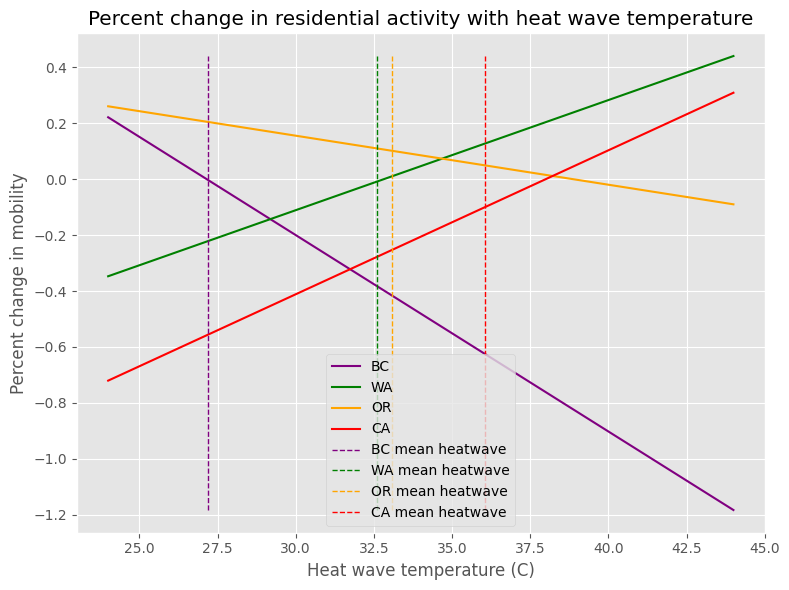

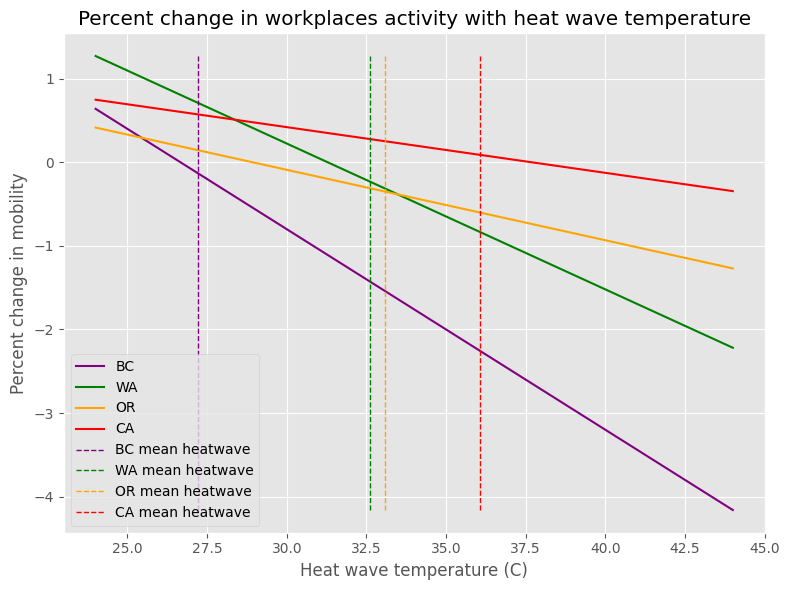

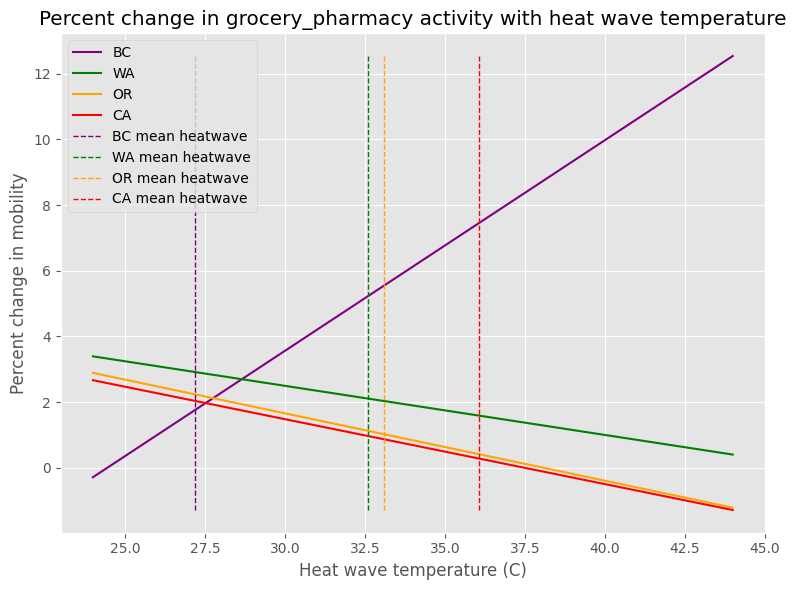

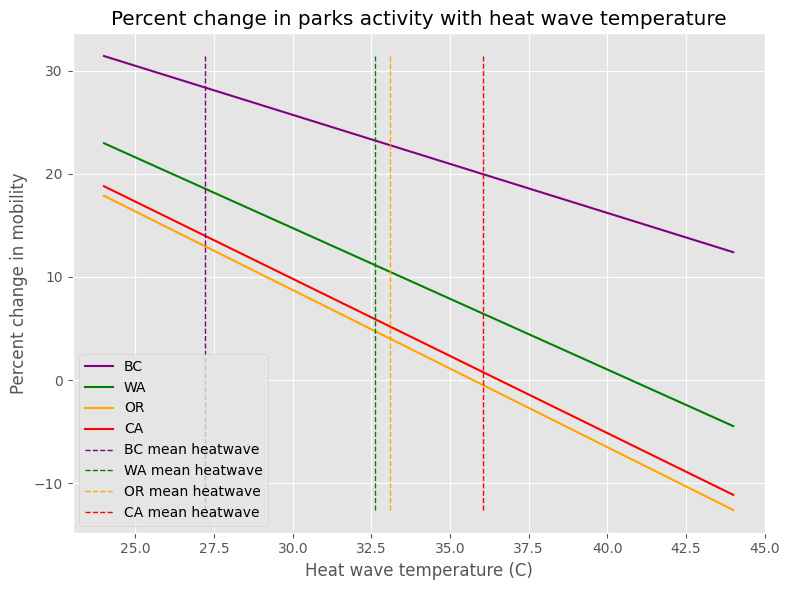

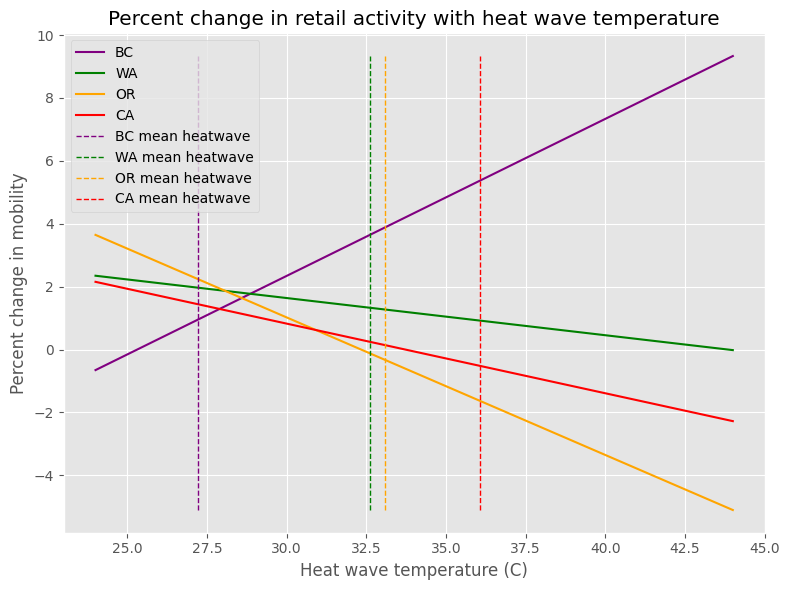

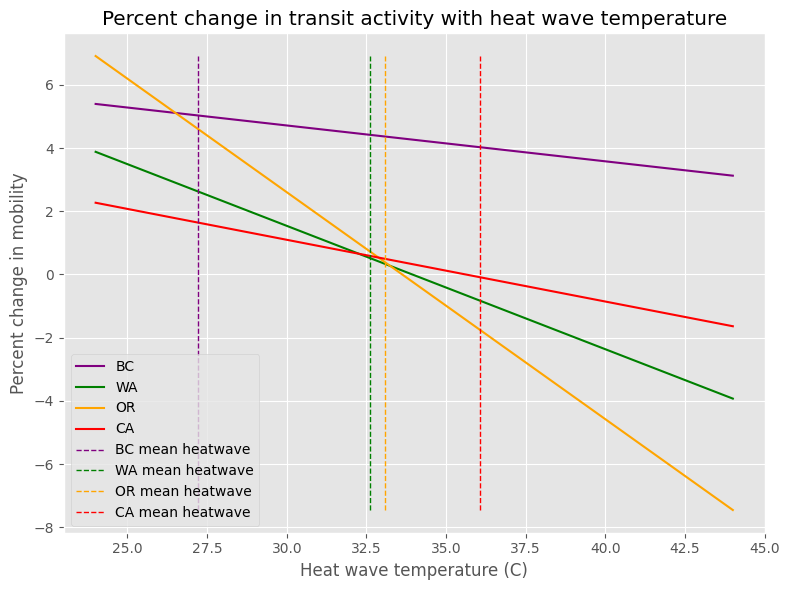

In [17]:
plot_regression('residential', params_dic)
plot_regression('workplaces', params_dic)
plot_regression('grocery_pharmacy', params_dic)
plot_regression('parks', params_dic)
plot_regression('retail', params_dic)
plot_regression('transit', params_dic)


### Create function which gathers average effects for each state into a dataframe

In [18]:
master = pd.DataFrame()
for response in ['residential', 'workplaces', 'transit', 'grocery_pharmacy', 'retail', 'parks']:
    
    bc_line = np.poly1d(params_dic[response]['British Columbia'])
    wa_line = np.poly1d(params_dic[response]['Washington'])
    or_line = np.poly1d(params_dic[response]['Oregon'])
    ca_line = np.poly1d(params_dic[response]['California'])
    
    x_axis = np.linspace(-10,10,20)
    bc_y_axis = bc_line(x_axis)
    wa_y_axis = wa_line(x_axis)
    or_y_axis = or_line(x_axis)
    ca_y_axis = ca_line(x_axis)
    
    bc = pd.DataFrame(x_axis, bc_y_axis)
    wa = pd.DataFrame(x_axis, wa_y_axis) 
    ore = pd.DataFrame(x_axis, or_y_axis)
    ca = pd.DataFrame(x_axis, ca_y_axis)
    
    bc['state'] = 'British Columbia'
    wa['state'] = 'Washington'
    ore['state'] = 'Oregon'
    ca['state'] = 'California'
    
    bc.reset_index(inplace=True)
    wa.reset_index(inplace=True)
    ore.reset_index(inplace=True)
    ca.reset_index(inplace=True)
    
    df = pd.concat([bc, wa, ore, ca])
    df['response'] = response
    
    master = master.append(df)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_20922/1988237988.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master = master.append(df)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_20922/1988237988.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master = master.append(df)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_20922/1988237988.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master = master.append(df)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_20922/1988237988.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master = master.append(df)
/var/folders/8g/qp1k

In [19]:
master.columns = ['change', 'temp', 'state', 'response']

In [20]:
master['temp'] += 33

In [22]:
#save dataframe to re-create plots in R
master.to_csv(data_path + 'results/reg_plots/data_v4.csv')